In [1]:
!nvidia-smi

Sat Apr 26 22:32:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.144                Driver Version: 570.144        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   41C    P4             14W /   80W |     341MiB /   6141MiB |     20%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#!pip install opencv-python numpy torch torchvision ultralytics matplotlib tqdm
#!pip install -q transformers sentencepiece gdown inference-gpu supervision more_itertools scikit-learn umap-learn
#!pip install -q git+https://github.com/roboflow/sports.git
#!pip3 install timm
#!pip install "inference[transformers,sam,clip,gaze,grounding-dino]"


  Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of accelerate to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
  Using cached sounddevice-0.5.1-py3-none-any.whl.metadata (1.4 kB)
  Preparing metadata (setup.py) ... done
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_

In [1]:
from utils import read_video, save_video
from tracker import Tracker
from team_assigner import TeamAssigner
from player_ball_assigner import PlayerBallAssigner
from camera_movement_estimator import CameraMovementEstimator
from view_transformer import ViewTransformer
from speed_and_distance_estimator import SpeedAndDistanceEstimator
import cv2
import numpy as np
import os
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#rom sports.common.team import TeamClassifier


cuda


In [ ]:
def main():
    video_frames = read_video('08fd33_4.mp4')

    tracker = Tracker('models/player_detection.pt')

    tracks = tracker.get_object_tracks(video_frames, read_from_stub=True, stub_path='stubs/track_stubs.pkl')

    tracker.add_position_to_track(tracks) # get obj positions
    
    team_assigner = TeamAssigner(device)
    team_assigner.assign_teams(tracks, video_frames, read_from_stub=True, stub_path='stubs/team_stubs.pkl')
    
    output_video_frames = tracker.draw_annotations(video_frames, tracks) #team_ball_control

    save_video(output_video_frames, 'output_video.avi')


if __name__ == '__main__':
    main()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Saving crops and player info to stubs/team_stubs.pkl...


Embedding extraction: 17it [00:02,  6.72it/s]
Embedding extraction: 480it [01:05,  7.37it/s]


In [3]:
from pitch import PitchAnnotator

def main():
    video_frames = read_video('08fd33_4.mp4')
    
    pitch_ann = PitchAnnotator(
        model_id="football-field-detection-f07vi/15",
        api_key="QbX06VaTIC5Q6ldwuNAc",
        conf=0.3
    )

    output_frames = []
    for frame in video_frames:
        # 1) draw your players/keepers/etc
        #out = tracker.draw_annotations([frame], tracks)[0]

        # 2) detect & draw pitch points
        pts = pitch_ann.detect_keypoints_frame(frame)
        if pts.size:
            out = pitch_ann.draw_points(frame, pts)

        output_frames.append(out)

    save_video(output_frames, 'pitch_output_video.avi')

if __name__ == '__main__':
    main()

In [4]:
from pitch import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

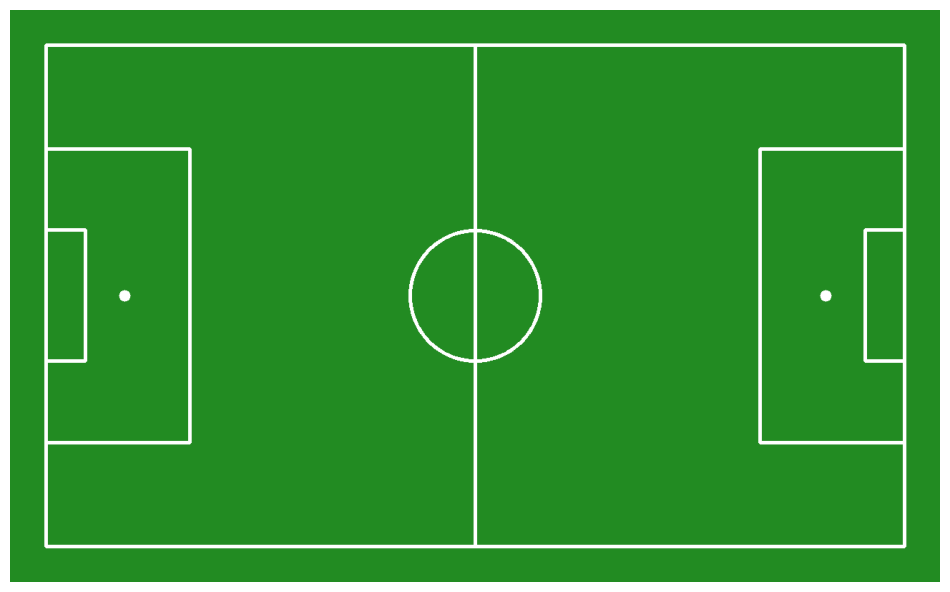

In [5]:
from pitch import draw_pitch
import supervision as sv

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

In [ ]:
'''
def main():
    video_frames = read_video('08fd33_4.mp4')

    tracker = Tracker('models/best.pt')

    tracks = tracker.get_object_tracks(video_frames, read_from_stub=True, stub_path='stubs/track_stubs.pkl')

    tracker.add_position_to_track(tracks) # get obj positions

    camera_movement_estimator = CameraMovementEstimator(video_frames[0])
    camera_movement_per_frame = camera_movement_estimator.get_camera_movement(video_frames, read_from_stub=True, stub_path='stubs/camera_movement_stubs.pkl')

    camera_movement_estimator.add_adjust_positions_to_tracks(tracks, camera_movement_per_frame)
    
    view_transformer = ViewTransformer()
    view_transformer.add_transformed_position_to_tracks(tracks)


    tracks['ball'] = tracker.interpolate_ball_positions(tracks['ball'])

    speed_and_distance_estimator = SpeedAndDistanceEstimator()
    speed_and_distance_estimator.add_speed_and_distance_to_tracks(tracks)

    team_assigner = TeamAssigner()
    team_assigner.assign_team_color(video_frames[0], tracks['players'][0])

    for frame_num, player_track in enumerate(tracks['players']):
        for player_id, track in player_track.items():
            team = team_assigner.get_player_team(video_frames[frame_num], track['bbox'], player_id)

            tracks['players'][frame_num][player_id]['team'] = team
            tracks['players'][frame_num][player_id]['team_color'] = team_assigner.team_colors[team]

    player_assigner = PlayerBallAssigner()
    team_ball_control = []
    for frame_num, player_track in enumerate(tracks['players']):
        ball_bbox = tracks['ball'][frame_num][1]['bbox']
        assigned_player = player_assigner.assign_ball_to_player(player_track, ball_bbox)

        if assigned_player != -1:
            tracks['players'][frame_num][assigned_player]['has_ball'] = True
            team_ball_control.append(tracks['players'][frame_num][assigned_player]['team'])
        else:
            team_ball_control.append(team_ball_control[-1])
    team_ball_control = np.array(team_ball_control)

    output_video_frames = tracker.draw_annotations(video_frames, tracks, team_ball_control)

    output_video_frames = camera_movement_estimator.draw_camera_movement(output_video_frames, camera_movement_per_frame)

    speed_and_distance_estimator.draw_speed_and_distance(output_video_frames, tracks)

    save_video(output_video_frames, 'output_video.avi')


if __name__ == '__main__':
    main()
'''